In [1]:
from utils.misc import *
from train_single_batch.train4 import Train_batch,Test
from datasets.data_utils import load_dataset
from model_single.Creat_model import creat_model

2025-03-24 21:15:50.646344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 21:15:50.922960: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 21:15:52.193430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2025-03-24 21:15:52.193532: W tensorflow/compiler/xla/stream_executor/p

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     

In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

load configs


In [6]:
import scanpy as sc
adata_omics1=sc.read_h5ad('/home/hfzhang/data/E10.5_E1S1.MOSTA.h5ad')
adata_omics1.var_names_make_unique()
n_clusters=len(set(adata_omics1.obs['annotation']))

In [8]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1 =  adata_omics1[:, adata_omics1.var['highly_variable']]

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [9]:
from utils.preprocess import *
from utils.utils import *

In [10]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [11]:
label = adata_omics1.obs['annotation'].astype(str) #先全部转成string  
label[pd.isna(label)] = "nan"  # 将缺失值替换为 "NA"，前提是你用了pandas
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [12]:
random_seed=2024
args.random_seed=random_seed
fix_seed(random_seed)
device='cuda:0'
args.n_input=adata_omics1.n_vars
# args.n_input1=adata_omics2.n_vars-1
args.n_clusters=len(classes)
args.n_clusters
args.Type='E10.5'
args.n_clusters=len(classes)

In [22]:
args.tool='kmeans'
args.sigma=0.2
args.lr=0.001
args.loss_n=0.01
args.loss_a=0.1

import numpy as np  

# 假设 adata 是你的 AnnData 对象  
# 将第二列（索引1）中的负值转换为正值  
adata_omics1.obsm['spatial'][:, 1] = np.abs(adata_omics1.obsm['spatial'][:, 1])  

In [15]:
args.batch_size=5000
args.input_size=adata_omics1.n_vars
args.sample_num=adata_omics1.n_obs

In [23]:

from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
def create_dataloader(data, adj, labels, batch_size=32):
    dataset = TensorDataset(data, adj, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader
class Dataloader(data.Dataset):
    def __init__(self, train=False, input_size=20, sample_num=50,data=None, seed=2022):
        self.train = train
        self.input_size=input_size
        self.sample_num=sample_num
        self.data=data 
    def __getitem__(self, index):
            sample = np.array(self.data[index])  
            return sample
    def __len__(self):
        return self.data.shape[0]

import math
class PrepareDataloader():
    def __init__(self, args,data=None):
        self.config = args
        # hardware constraint
        kwargs = {'num_workers': 0, 'pin_memory': False} 

        self.sample_num = 0
        self.batch_size = 0

        trainset = Dataloader(True, args.input_size, args.sample_num, data)
        self.sample_num += len(trainset)
        # adjust the size of mini-batch in case that the size of the last batch is too small which may lead biased results.
        if (self.sample_num % args.batch_size) < (0.1*args.batch_size):
            self.batch_size = args.batch_size + math.ceil((self.sample_num % args.batch_size)/(self.sample_num//args.batch_size))
        else:
            self.batch_size = args.batch_size

        train_loader = torch.utils.data.DataLoader(trainset, batch_size=
            self.batch_size, shuffle=False,   **kwargs) # mini-batches used for training are shuffled in this step.


        self.train_loader = train_loader
        print("sample_num :", self.sample_num)
        print("batch_size :", self.batch_size)

    def getloader(self):
        return self.train_loader,  math.ceil(self.sample_num/self.batch_size)
    
X = adata_omics1.X  # 这是一个二维数组  
spatial_coords = adata_omics1.obsm['spatial']
combined_array = np.hstack((X, spatial_coords))
features_omics1_train = torch.FloatTensor(combined_array.copy())
train_loader,training_iters = PrepareDataloader(
            args=args,data=features_omics1_train).getloader()

args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
labels = torch.LongTensor(label)  # 转换为 Tensor
model = creat_model('spamgcn', args).to(args.device)
model=Train_batch(100, model, train_loader, label , args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,train_loader,label,args,'kmeans')

sample_num : 18408
batch_size : 5000
Epoch_  0 , nmi 0.5155 , ari 0.3063 , ami 0.5146 , homogeneity 0.5464 , completeness 0.4878 , v_measure 0.5155
聚类方法为kmeans
test
name: acm
NMI : 0.5155
ARI : 0.3063
AMI  : 0.5146


/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


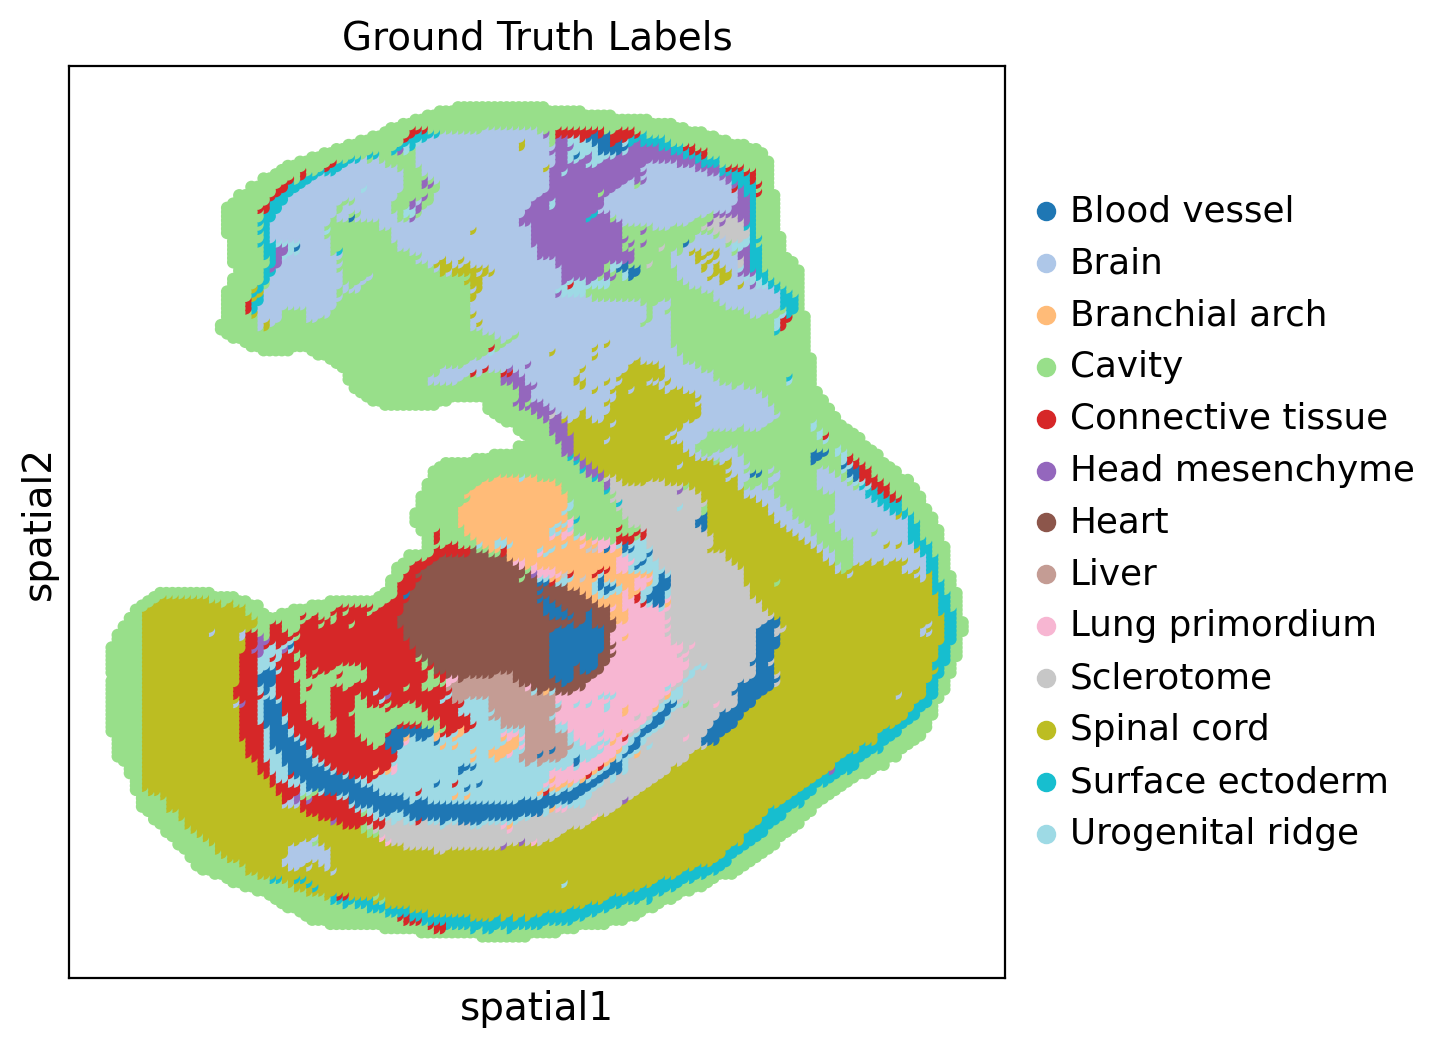

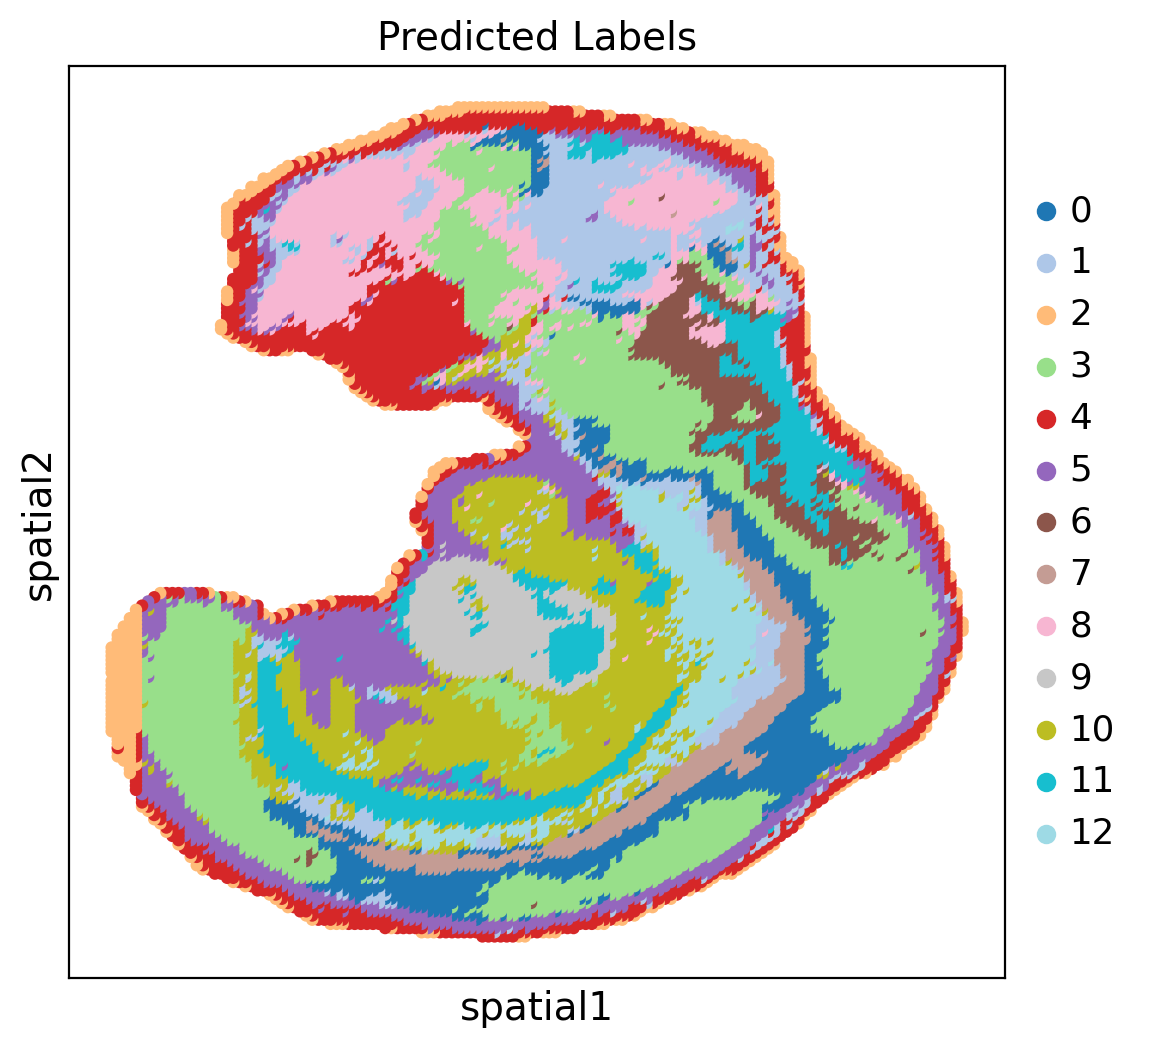

In [27]:
import scanpy as sc
import matplotlib.pyplot as plt

# 假设你已经有一个 AnnData 对象 adata_omics1_train
# adata_omics1_train 包含降维后的嵌入（例如 UMAP 或 t-SNE）和 obs 中的 ground_truth 和 pred 列

# 1. 检查 AnnData 对象
# print(adata_omics1_train)

# 2. 设置绘图参数
sc.set_figure_params(figsize=(6, 6), dpi=100)

# 3. 绘制真实标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='annotation',  # 使用 obs 中的 ground_truth 列作为颜色
    title='Ground Truth Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=80,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 4. 绘制预测标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='pred',  # 使用 obs 中的 pred 列作为颜色
    title='Predicted Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=80,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 5. 显示图像
plt.show()